# Incorrect units

During the conversion from raw model output to zarr format, units were incorrectly assigned to the variables `"precip"` and `"evap"` in the forecast files `atmos_isobaric_month.zarr.zip`. These variables were processed from the daily files by summing them over months, but the units attributes were not changed from the daily files. Thus, the data can be corrected by normalising `"precip"` and `"evap"` by the number of days in each month, as demonstrated for a single forecast below.

In [1]:
import xarray as xr

import numpy as np

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 12

_ = xr.set_options(keep_attrs=True)

In [3]:
variables = ["precip", "evap"]

cafe = xr.open_zarr(
    "../data/raw/CAFEf6/c5-d60-pX-f6-20191101/atmos_isobaric_month.zarr.zip"
)[variables]

## Correct the data by normalising by the number of days in each month

In [4]:
def normalise_by_days_in_month(ds):
    """
    Normalise input array by the number of days in each month

    Parameters
    ----------
    ds : xarray Dataset
        The array to normalise
    """
    # Cast days as float32 to avoid promotion to float64
    return ds / ds["time"].dt.days_in_month.astype(np.float32)

In [5]:
cafe_corrected = normalise_by_days_in_month(cafe)

## Compare renormalised CAFE data to GPCP data

In [6]:
gpcp = xr.open_mfdataset("../data/raw/GPCP/2020/gpcp*.nc")

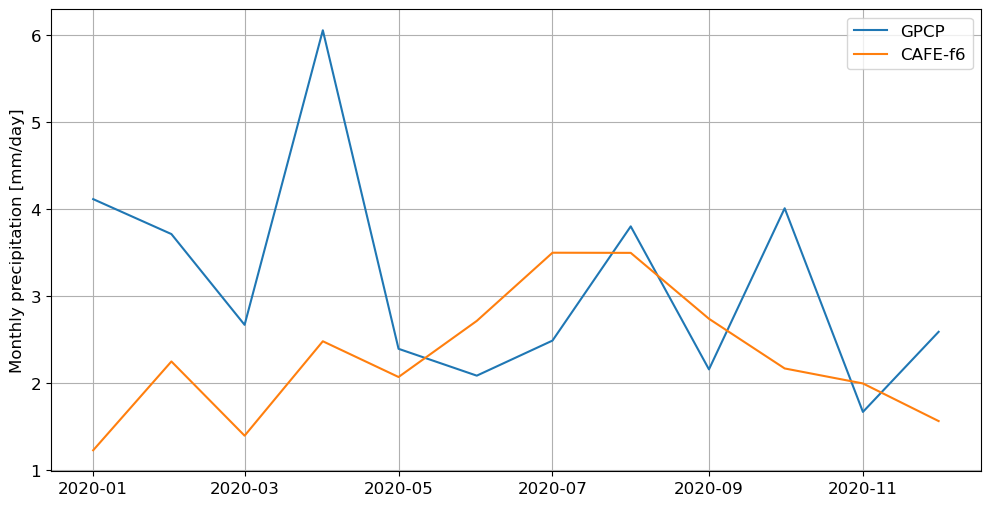

In [7]:
# Somewhere near Melbourne
lon = 145
lat = -37.8

gpcp_Melb = gpcp["precip"].sel(longitude=lon, latitude=lat, method="nearest")
cafe_Melb = (
    (86400 * cafe_corrected["precip"])  # Convert from kg/m2/s to mm/day
    .sel(lon=lon, lat=lat, ensemble=1, method="nearest")
    .sel(time="2020")
)

plt.plot(gpcp_Melb.time, gpcp_Melb, label="GPCP")
plt.plot(gpcp_Melb.time, cafe_Melb, label="CAFE-f6")
plt.ylabel("Monthly precipitation [mm/day]")
plt.legend()
plt.grid()